# Analiza klasičnega klavirskega repertoarja

V tem projektu analiziramo podatke o klasičnem klavirskem repertoarju iz spletne strani [pianolibrary.org](https://www.pianolibrary.org). Na voljo so nam podatki o naslovih, trajanjih in težavnostih večine objavljenih klavirskih del večine bolj znanih skladateljev. Poleg tega imamo za določena dela na voljo oceno leta izdaje, iz naslovov pa lahko včasih izluščimo še informacije o tonaliteti in tempu dela.

Nekatera dela so sestavljena iz večih skladb, stavkov oziroma drugih komponent. Za te komponente imamo po večini na voljo enake kategorije podatkov kot za dela sama.

Za začetek si poglejmo, koliko podatkov smo uspeli nabrati.

In [1]:
import analiza
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np

skladbe = analiza.pridobi_skladbe()
df_skladbe = pd.DataFrame(skladbe,
                          columns=['id', 'ime', 'priimek', 'rojstvo', 
                                   'smrt', 'naslov', 'izdaja', 
                                   'trajanje', 'tezavnost', 'tonaliteta', 
                                   'tempo', 'st_delov', 'naslovi_delov', 
                                   'trajanja_delov', 'tezavnosti_delov', 
                                   'tonalitete_delov', 'tempi_delov'])
df_skladbe['desetletje'] = (df_skladbe['izdaja'] // 10 * 10).astype('Int64')
df_skladbe['petdesetletje'] = (df_skladbe['izdaja'] // 50 * 50).astype('Int64')

print(f'Število nabranih del: {len(df_skladbe)}.')
print(f'Število del z znanim letom izdaje: {len(df_skladbe["izdaja"].dropna())}.')
print(f'Število del z znano tonaliteto: {len(df_skladbe["tonaliteta"].dropna())}.')
print(f'Število del z znanim tempom: {len(df_skladbe["tempo"].dropna())}.')
print(f'Število delov del: {df_skladbe['st_delov'].sum()}.')
print(f'Število delov del z znano tonaliteto: {len(df_skladbe["tonalitete_delov"].explode().dropna())}.')
print(f'Število delov del z znanim tempom: {len(df_skladbe["tempi_delov"].explode().dropna())}.')

Število nabranih del: 2205.
Število del z znanim letom izdaje: 1549.
Število del z znano tonaliteto: 1475.
Število del z znanim tempom: 65.
Število delov del: 5586.
Število delov del z znano tonaliteto: 3032.
Število delov del z znanim tempom: 886.


Skupno število vseh del in delov del je torej precej veliko. Leto izdaje je podano pri veliki večini (približno treh četrtinah) vseh del, podobno je s tonaliteto, zato bomo o teh kategorijah podatkov znali precej povedati. Pri tempu pa smo imeli manj sreče. Tako kot tonaliteta, tempo ni eksplicitno podan na spletni strani in ga moramo izluščiti iz naslovov skladb, žal pa je podajanje informacij o tempu v naslovih dosti manj popularno in smo ga uspeli pridobiti le za okoli 16% del.

Za začetek si torej poglejmo bolj splošne statistike, začenši s številom izdanih del skozi čas.

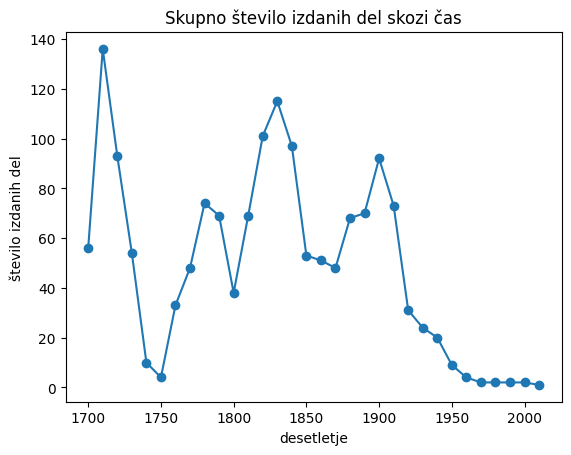

In [2]:
df_skladbe.groupby(['desetletje']).size().plot(marker='o')
plt.title('Skupno število izdanih del skozi čas')
plt.ylabel('število izdanih del')
plt.show()

Opaziti se da nekaj zanimivih vrhov in dolin. Najopaznejši vrh je na začetku grafa, ki izvira iz ogromnih opusov baročnih skladateljev kot so Bach, Handel in Scarlatti, ki so ustvarili mnogo krajših skladb. Takoj za tem vrhom sledi najopaznejša dolina okoli sredine 18. stoletja. To se ujema s splošno priznanim koncem baročnega obdobja. Sledijo vrhovi v vrhu klasicizma, zgodnje romantike in pozne romantike.

Na grafu je videti, da se je po svetovnih vojnah popularnost klavirske glasba zmanjšala. Menim pa, da je verjetnejša razlaga to, da nam preprosto manjka "zgodovinski pogled" na to obdobje - ljudje še nismo imeli časa, da bi prepoznali pomembnejše skladatelje (na naši spletni strani je namreč navedenih zelo malo modernih skladateljev).

Morda je zaradi prej omenjenega kratkega a številnega opusa baročnih skladateljev pravičnejša presoja o popularnosti klavirske glasbe možna s pomočjo grafa skupnega trajanja skladb skozi čas.

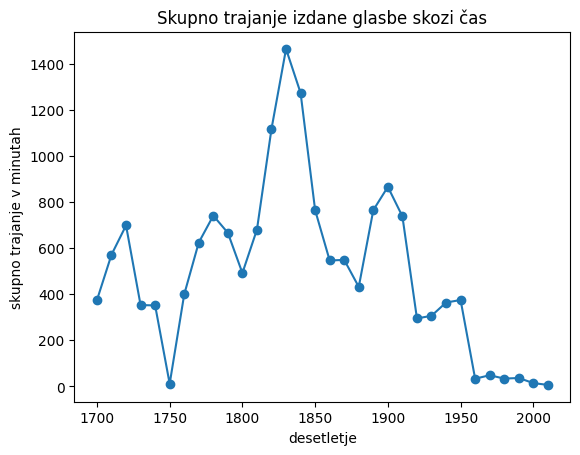

In [3]:
df_skladbe.groupby(['desetletje'])['trajanje'].sum().plot(marker='o')
plt.title('Skupno trajanje izdane glasbe skozi čas')
plt.ylabel('skupno trajanje v minutah')
plt.show()

Tu vidimo, da je "največ" znane klavirske glasbe pravzaprav nastalo v času romantike (kar je seveda znano vsem, ki to glasbo občasno poslušajo). Dominanca baroka se je ustrezno zmanjšala.

Kako se je trajanje posameznih del spreminjalo skozi čas, in kako se to primerja s trajanjem skladb (delov del)? Da poskusimo odgovoriti na ta vprašanja, uporabimo metodo najmanjših kvadratov za prileganje premice k podatkom.

V povprečju se vsako leto dela podaljšajo za 1.5 sekund!
V povprečju se vsako leto skladbe podaljšajo za 0.2 sekund!


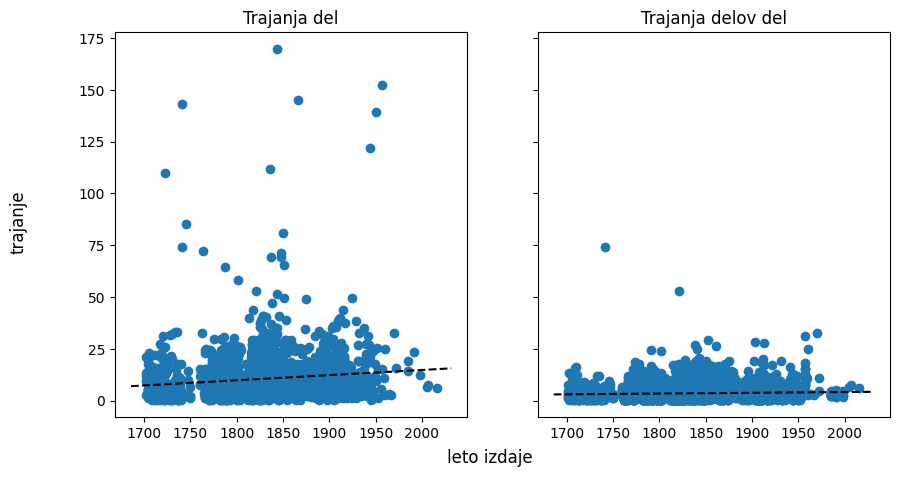

In [4]:
k1,n1=np.polyfit(df_skladbe['izdaja'].dropna(), df_skladbe.dropna(subset='izdaja')['trajanje'], 1)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(df_skladbe['izdaja'], df_skladbe['trajanje'], 'o')
xmin, xmax = ax[0].get_xlim()
ax[0].plot([xmin, xmax], [k1*xmin+n1, k1*xmax+n1], 'k--')
ax[0].set_title('Trajanja del')

print(f'V povprečju se vsako leto dela podaljšajo za {round(k1*60, 1)} sekund!')

df_trajanja_delov = df_skladbe.explode('trajanja_delov').astype({'trajanja_delov': 'Float64'})
k2,n2=np.polyfit(df_trajanja_delov['izdaja'].dropna(),
                 df_trajanja_delov.dropna(subset='izdaja')['trajanja_delov'], 1)
ax[1].plot(df_trajanja_delov['izdaja'], df_trajanja_delov['trajanja_delov'], 'o')
ax[1].plot([xmin, xmax], [k2*xmin+n2, k2*xmax+n2], 'k--')
ax[1].set_title('Trajanja delov del')
fig.supxlabel('leto izdaje')
fig.supylabel('trajanje')
fig.set_size_inches(10,5)

print(f'V povprečju se vsako leto skladbe podaljšajo za {round(k2*60, 1)} sekund!')

Kot vidimo, se trajanje del rahlo daljša skozi čas - raste približno 1,5 sekund na leto. Pri delih del je ta rast dosti manj opazna. Iz tega lahko sklepamo, da se popularnost večdelnih kompozicij veča.

Še ena zanimivost je, da je najdaljša skladba v našem katalogu nastala že v času baroka: gre za Bachove "Goldbergove variacije". Kljub temu da je sestavljena iz arie in tridesetih variacij se načeloma šteje za neprekinjeno skladbo, ki v modernih izvedbah traja okoli eno uro. Zanimivo bi si bilo ogledati še drug ekstrem: dela, sestavljena iz mnogih skladb. Oglejmo si torej pet najbolj razdrobljenih del.

In [5]:
df_skladbe.sort_values(by='st_delov', ascending=False).head()

,id,ime,priimek,rojstvo,smrt,naslov,izdaja,trajanje,tezavnost,tonaliteta,tempo,st_delov,naslovi_delov,trajanja_delov,tezavnosti_delov,tonalitete_delov,tempi_delov,desetletje,petdesetletje
2048,schumann,Robert,Schumann,1810,1856,"Album für die Jugend, op. 68",1848.0,71.0,3.0,None,NaN,89,"[1. Melodie, 2. Soldatenmarsch, 3. Trällerlied...","[1.0, 0.5, 1.0, 1.5, 1.0, 1.5, 1.0, 0.5, 1.5, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 2.0, 1.5, 1.5, ...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",1840,1800
104,bach,Johann Sebastian,Bach,1685,1750,"The Well-Tempered Clavier, Book 2, BWV 870–893",1740.5,143.0,4.0,None,NaN,55,"[1. C major, BWV 870, Prelude (first final ver...","[2.5, 2.5, 1.0, 1.5, 1.5, 2.5, 2.5, 2.0, 2.0, ...","[3.0, 3.0, 2.5, 3.0, 3.0, 2.5, 3.0, 3.0, 2.5, ...","[C dur, C dur, C dur, C dur, C dur, C mol, C m...","[None, None, None, None, None, None, None, Non...",1740,1700
1152,mozart,Wolfgang Amadeus,Mozart,1756,1791,"London Sketchbook, KV 15a–15ss",1764.0,72.0,2.5,None,NaN,52,"[1. Piece in F major, KV 15a, 2. Piece in C ma...","[1.0, 1.5, 1.0, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, ...","[1.5, 1.5, 1.0, 1.5, 1.5, 1.5, 2.0, 1.5, 1.0, ...","[F dur, C dur, G dur, D dur, G dur, C dur, G d...","[None, None, None, None, None, None, None, Non...",1760,1750
59,bach,Johann Sebastian,Bach,1685,1750,"The Well-Tempered Clavier, Book 1, BWV 846–869",1722.0,110.0,4.0,None,NaN,50,"[1. C major, BWV 846, Prelude, 1. C major, BWV...","[1.5, 1.0, 2.0, 1.5, 1.5, 1.5, 2.5, 3.0, 4.5, ...","[1.0, 1.0, 3.5, 2.5, 2.5, 2.5, 3.5, 2.5, 3.5, ...","[C dur, C dur, C dur, C mol, C mol, Cis dur, C...","[None, None, None, None, None, None, None, Non...",1720,1700
2161,shostakovich,Dmitri,Shostakovich,1906,1975,"Twenty-four Preludes and Fugues, op. 87",1950.5,139.5,5.0,None,NaN,48,"[1. C major, Prelude, 1. C major, Fugue, 2. A ...","[2.5, 2.5, 1.0, 1.5, 2.0, 2.0, 2.0, 5.5, 1.5, ...","[2.5, 3.0, 3.0, 3.5, 2.5, 3.5, 3.0, 3.5, 2.5, ...","[C dur, C dur, A mol, A mol, G dur, G dur, E m...","[None, None, None, None, None, None, None, Non...",1950,1950


Kar tri dela na seznamu (Šostakovičevo delo in pa Bachovi zbirki Dobro uglašeni klavir) so kolekcije preludijev in fug v vseh tonalitetah, kar skupaj znese vsaj $2\times24=48$ skladb. Zraven sta se znašli še Mozartova zbirka kompozicijskih vaj iz otroštva in pa Schumannov Album za otroke, ki ga je posvetil svojim trem hčeram.

Nadaljujmo z analizo trajanja. Oglejmo si še graf povprečnega trajanja skladb skozi leta in skupno porazdelitev trajanja skladb.

Od vseh 5586 skladb jih 4034 traja največ 4 minute.


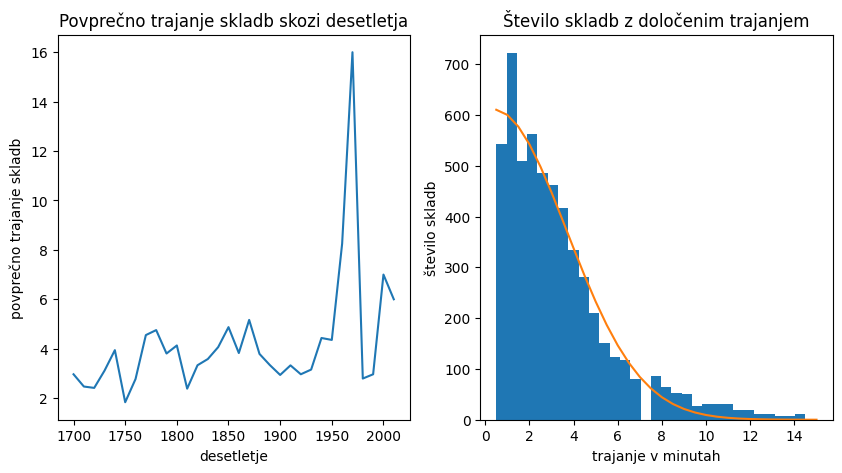

In [6]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(df_trajanja_delov.groupby('desetletje')['trajanja_delov'].mean())
ax[0].set_title('Povprečno trajanje skladb skozi desetletja')
ax[0].set_xlabel('desetletje')
ax[0].set_ylabel('povprečno trajanje skladb')

ax[1].hist(df_trajanja_delov[df_trajanja_delov['trajanja_delov'] < 15]['trajanja_delov'], bins=30)

def gauss(x, amplituda, povprecje, odklon):
    return amplituda * np.exp(-((x - povprecje) / (4 * odklon)) ** 2)

razpon = np.linspace(0.5, 15, 30)
optimum, _ = optimize.curve_fit(gauss, razpon, df_trajanja_delov[df_trajanja_delov['trajanja_delov'] <= 15].groupby('trajanja_delov').size())
ax[1].plot(razpon, gauss(razpon, *optimum))
ax[1].set_title('Število skladb z določenim trajanjem')
ax[1].set_xlabel('trajanje v minutah')
ax[1].set_ylabel('število skladb')

fig.set_size_inches(10, 5)

print(f'Od vseh {df_skladbe['st_delov'].sum()} skladb jih {len(df_trajanja_delov[df_trajanja_delov["trajanja_delov"] <= 4])} traja največ 4 minute.')


Zdi se, da je najpriljubljenejše trajanje skladb tako rekoč fiksno skozi zgodovino, do odstopanj pride le v moderni zgodovini, za katero nam primanjkuje podatkov. To se ujema z našim prejšnjim grafom trajanja del v odvisnosti od izdaje. Najpopularnejše so kvečjemu 4 minute dolge skladbe: takih je več kot 4000 (od približno 5500). Zanimivo je, da se trajanje na videz ujema z normalno porazdelitvijo. To se (zaradi centralnega limitnega izreka) sklada s tem, da so trajanja posameznih skladb večinoma neodvisne spremenljivke.

Dovolj analize trajanja za zdaj. Oglejmo si nekaj bolj muzikološko zanimivega: tonalitete.

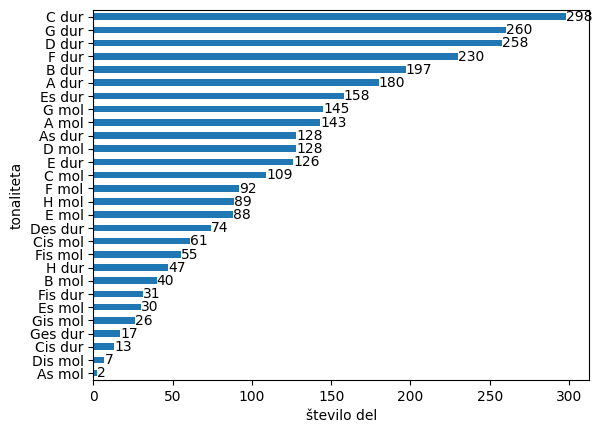

In [7]:
ax = df_skladbe['tonalitete_delov'].explode().value_counts(ascending=True).plot(kind='barh')
ax.bar_label(ax.containers[0])
ax.set_xlabel('število del')
ax.set_ylabel('tonaliteta')
plt.show()

Kot gre pričakovati, dominirajo najpreprostejše tonalitete, večinoma duri, "vesele" tonalitete. To se ujema z dejstvom, da so v klasičnem obdobju moli, bolj "tragične" tonalitete, bili dosti manj priljubljeni. Takrat je bila namreč velika večina glasbe napisana v namen zabavanja aristokratov na dvoru. Kasneje, posebej v pozni romantiki, so moli postali nekoliko popularnejši zaradi svoje ekspresivnosti.

In kaj sta ti dve osamljeni skladbi v as molu, najredkejši tonaliteti?

In [8]:
df_skladbe[df_skladbe['tonalitete_delov'].apply(lambda x: 'As mol' in x)]

,id,ime,priimek,rojstvo,smrt,naslov,izdaja,trajanje,tezavnost,tonaliteta,tempo,st_delov,naslovi_delov,trajanja_delov,tezavnosti_delov,tonalitete_delov,tempi_delov,desetletje,petdesetletje
1005,liszt,Franz,Liszt,1811,1886,Six Études d’exécution transcendante d’après P...,1838.0,27.5,5.0,None,NaN,8,"[1. G minor, 2. E-flat major, 3. A-flat minor,...","[5.0, 5.5, 4.5, 2.5, 4.0, 4.0, 4.0, 6.0]","[4.0, 5.0, 5.0, 5.0, 5.0, 4.5, 4.5, 5.0]","[G mol, Es dur, As mol, E dur, E dur, E dur, E...","[None, None, None, None, None, None, None, None]",1830,1800
1935,schubert,Franz,Schubert,1797,1828,"Twelve deutsche Tänze, D 790",1823.0,10.0,2.5,None,NaN,12,"[1. D major, 2. A major, 3. D major, 4. D majo...","[1.5, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, ...","[2.5, 2.5, 2.0, 2.5, 2.0, 2.5, 1.5, 2.0, 2.0, ...","[D dur, A dur, D dur, D dur, H mol, Gis mol, A...","[None, None, None, None, None, None, None, Non...",1820,1800


Gre za tretjo etudo iz Lisztove prve izdaje njegovih Velikih Paganinijevih etud ter osmega od Schubertovih dvanajstih Nemških plesov.

Zdaj si pa poglejmo, kako so se ti deleži tonalitet spreminjali skozi čas.

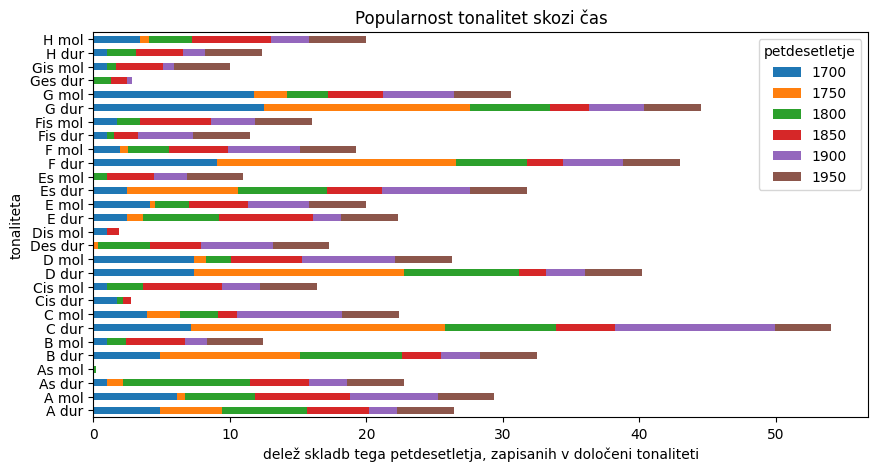

In [9]:
df_tonalitete_del = df_skladbe.explode('tonalitete_delov')
df_tonalitete_del = df_tonalitete_del.dropna(subset=['tonalitete_delov', 'petdesetletje'])

stevilo_tonalitet = df_tonalitete_del.groupby(['petdesetletje', 'tonalitete_delov']).size().unstack(fill_value=0)
delez_tonalitet = (stevilo_tonalitet.div(stevilo_tonalitet.sum(axis=1), axis=0) * 100).T

delez_tonalitet.plot(kind='barh', figsize=(10,5), stacked=True)
plt.title('Popularnost tonalitet skozi čas')
plt.xlabel('delež skladb tega petdesetletja, zapisanih v določeni tonaliteti')
plt.ylabel('tonaliteta')
plt.show()

Med drugim opazimo prej omenjeno prevlado preprostih durov v klasicizmu (obdobju med približno 1750 do 1800). Vidimo tudi, da so v modernih časih (od 1900 dalje) tonalitete dosti bolj enakomerno uporabljene.

Za konec si dovolimo še eno očem prijaznejšo predstavo zgodovinske bitke dura in mola.

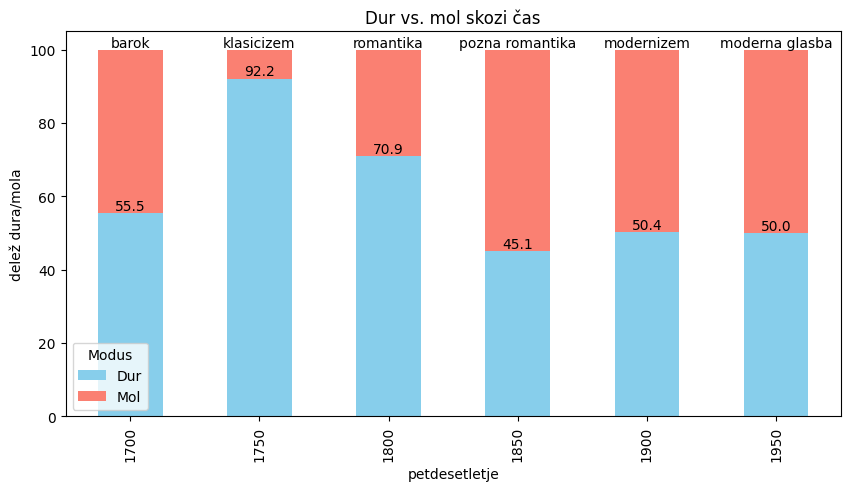

In [10]:
def modus(tonaliteta):
    if 'dur' in tonaliteta:
        return 'Dur'
    else:
        return 'Mol'

df_tonalitete_del['modus'] = df_tonalitete_del['tonalitete_delov'].apply(modus)

stevilo_modusov = df_tonalitete_del.groupby(['petdesetletje', 'modus']).size().unstack(fill_value=0)
delez_modusov = stevilo_modusov.div(stevilo_modusov.sum(axis=1), axis=0) * 100

ax = delez_modusov[['Dur', 'Mol']].plot(kind='bar', stacked=True, figsize=(10,5), color=['skyblue', 'salmon'])
ax.set_title('Dur vs. mol skozi čas')
ax.bar_label(ax.containers[0], fmt='%.1f')
ax.bar_label(ax.containers[1], labels=['barok', 'klasicizem', 'romantika', 'pozna romantika', 'modernizem', 'moderna glasba'])
ax.set_xlabel('petdesetletje')
ax.set_ylabel('delež dura/mola')
ax.legend(title='Modus')
plt.show()

Osredotočimo se zdaj na skladatelje in njihove življenjske poti. V naslednjem grafu si za deset skladateljev z največjim opusom oglejmo, koliko skladb so izdali skozi desetletja.

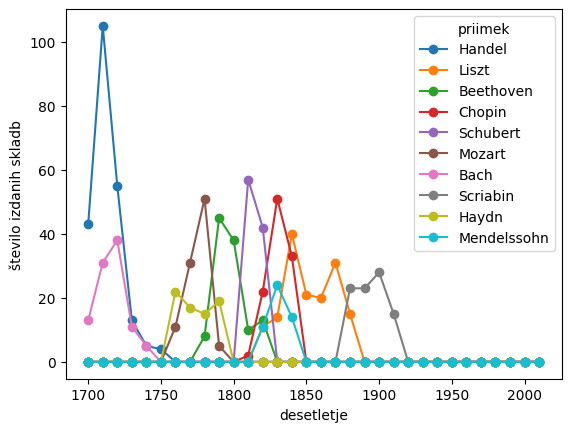

In [11]:
dejavnost_skladateljev = df_skladbe.groupby(['desetletje', 'priimek']).size().unstack(fill_value=0)
top_skladatelji = dejavnost_skladateljev.sum().sort_values(ascending=False).head(10).index
dejavnost_skladateljev[top_skladatelji].plot(marker='o')
plt.ylabel('število izdanih skladb')
plt.show()

Zanimivo je, kako malo prekrivanja je med leti njihove največje aktivnosti. Skoraj vsak ima svoje obdobje dominance, v katerem je odgovoren za večino izdanih skladb, ki so se uspele ohraniti. Posebej je vredno omeniti zaporedje Mozarta, Beethovna, Schuberta, Chopina, Liszta in Scriabina, ki so si tako na grafu kot tudi v resnici zelo sorodni - vsak med njimi za svoj navdih ogromno dolguje vsem prejšnjim.

Navkljub tem besedam je čas, da otvorimo t.i. "bitko skladateljev". Za začetek jih primerjajmo po številu izdanih skladb.

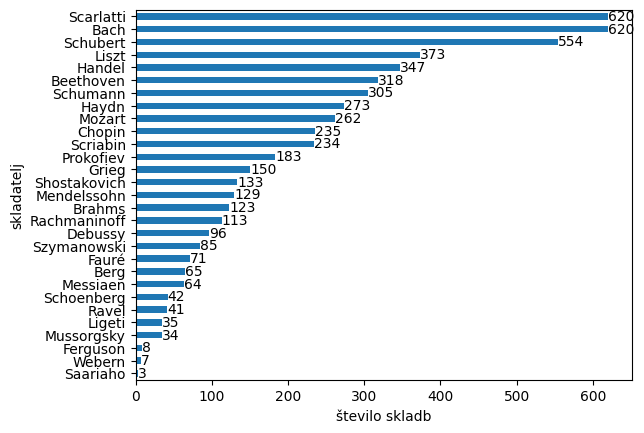

In [12]:
ax = df_trajanja_delov.groupby('priimek').size().sort_values().plot(kind='barh')
plt.bar_label(ax.containers[0])
plt.xlabel('število skladb')
plt.ylabel('skladatelj')
plt.show()

Kot je na tej točki že pričakovano, sta na vrhu dva baročna skladatelja. Bolj zanimivo je, da jima je Schubert, ki je umrl že pri 31. letu, tako blizu. Kako pa se odrežejo, ko jih primerjamo po skupnem trajanju skladb?

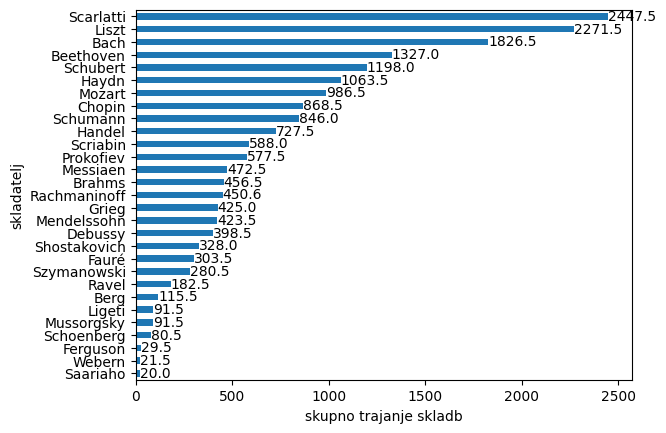

In [13]:
ax = df_skladbe.groupby('priimek')['trajanje'].sum().sort_values().plot(kind='barh')
plt.bar_label(ax.containers[0], fmt='%.1f')
plt.xlabel('skupno trajanje skladb')
plt.ylabel('skladatelj')
plt.show()

Presenetljivo je Scarlatti še vedno na vrhu, Schubert se je za nekaj mest spustil, Liszt pa se dvignil na drugo mesto. Na sploh je večina skladateljev uvrščenih podobno kot na prejšnjem grafu. To se sklada s prej opaženim dejstvom, da le redke skladbe močno izstopajo po trajanju.

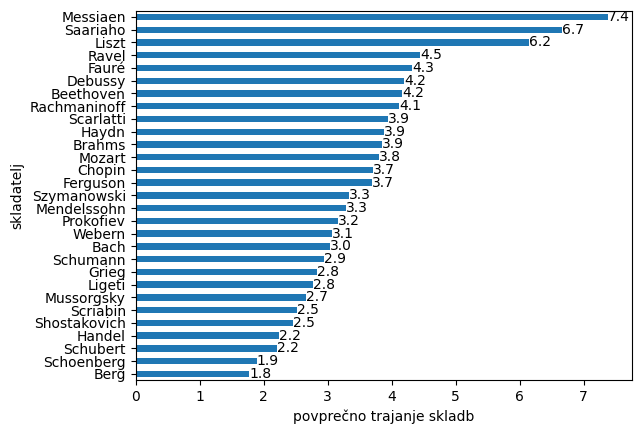

In [14]:
ax = df_trajanja_delov.groupby('priimek')['trajanja_delov'].mean().sort_values().plot(kind='barh')
plt.bar_label(ax.containers[0], fmt='%.1f')
plt.xlabel('povprečno trajanje skladb')
plt.ylabel('skladatelj')
plt.show()

Zares gre za precej enakomerno razporeditev. Opazimo pa lahko tri izjeme, skladatelje, ki so pisali dosti daljše skladbe od ostalih. Messiaen in Saariaho sta modernejša, kar delno upraviči njuno posebnost, Liszt pa takega izgovora nima. Nikdar ni izdal večjih zbirk krajših skladb, zato je večina njegovega opusa pač sestavljena iz daljših.

A ta skladatelj je znan še po nečem drugem. V času svojega življenja je zaslovel kot legendaren pianist, ki je s kombinacijo svoje tehnične dovršenosti in kreativnosti za vedno spremenil klavirsko glasbo. Poglejmo si še ostale skladatelje, ki jim je bolj mar za razvoj izraznih zmožnosti klavirja kot za udobje pianistov.

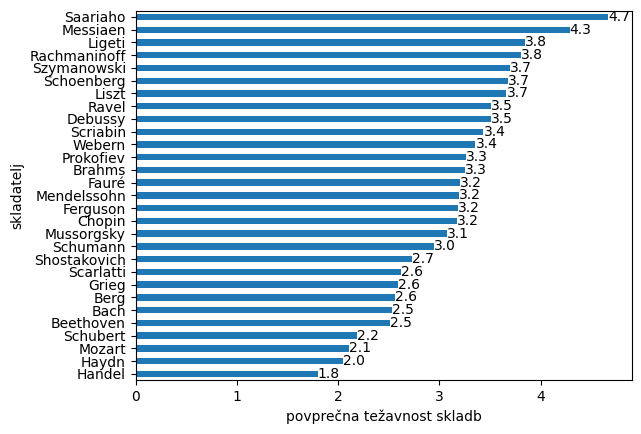

In [15]:
ax = df_skladbe.explode('tezavnosti_delov').groupby('priimek')['tezavnosti_delov'].mean().sort_values().plot(kind='barh')
plt.bar_label(ax.containers[0], fmt='%.1f')
plt.xlabel('povprečna težavnost skladb')
plt.ylabel('skladatelj')
plt.show()

Na vrhu so, kot je bilo pričakovano, sodobni skladatelji, ki pri raziskovanju novih zvokov ne posvečajo veliko pozornosti njihovi dejanski izvedljivosti. Najdemo pa tudi nekaj virtuozov, kot sta Liszt in Rachmaninoff.

Ena izmed najbolj spoštovanih glasbenih oblik je sonata. V grobem je to neko večstavčno (običajno štiristavčno), tematično in motivno kohezivno delo s približno določeno strukturo. Poglejmo si, kateri skladatelji so bili najuspešnejši v pisanju sonat.

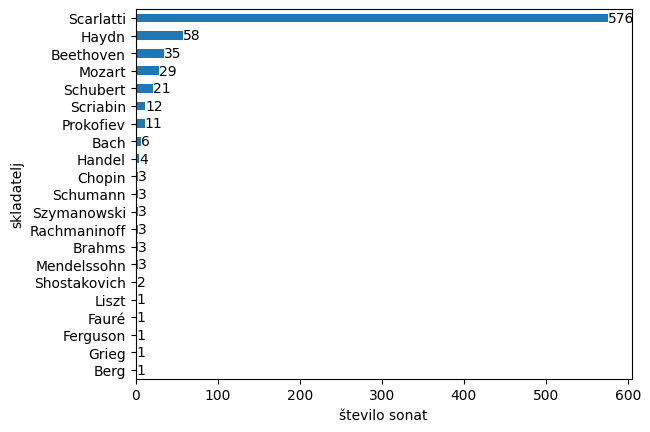

In [16]:
ax = df_skladbe[df_skladbe['naslov'].str.contains(r'^Sonata')].groupby(['priimek']).size().sort_values().plot(kind='barh')
ax.bar_label(ax.containers[0])
ax.set_xlabel('število sonat')
ax.set_ylabel('skladatelj')
plt.show()

Jasni zmagovalec je baročni skladatelj Domenico Scarlatti. A tu moramo biti pazljivi: natančen pomen sonate se je seveda spreminjal skozi čas. Baročne sonate so običajno enostavčne in veliko krajše od poznejših. Če želimo videti, kdo je pisal "najimpresivnejše" sonate, moramo pogledati njihovo povprečno dolžino.

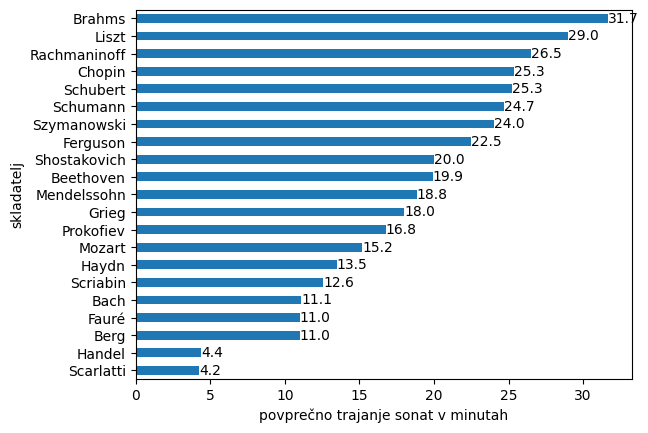

In [17]:
ax = df_skladbe[df_skladbe['naslov'].str.contains(r'^Sonata')].groupby(['priimek'])['trajanje'].mean().sort_values().plot(kind='barh')
plt.bar_label(ax.containers[0], fmt='%.1f')
plt.xlabel('povprečno trajanje sonat v minutah')
plt.ylabel('skladatelj')
plt.show()

Tu zmagujejo romantični skladatelji, klasicistični in modernistični so nekje vmes, baročni pa so odločno zadnji. To seveda ne bi smel biti konec zgodbe, saj so po mojem mnenju moderne sonate kljub krajšemu trajanju ravno tako impresivne kot romantične zaradi njihove kompleksnejše strukture. A analiza strukture skladb je nad našim nivojem (in pomembneje, nad podatki, ki jih imamo na voljo).

Vemo že, da je najbolj depresivno glasbeno obdobje pozna romantika. Naravno vprašanje je, kateremu izmed skladateljev pripada ta čast. Ker za nekatere skladatelje nimamo veliko podatkov, bomo v to primerjavo vključili le tiste, ki imajo vsaj 10 skladb z znano tonaliteto.

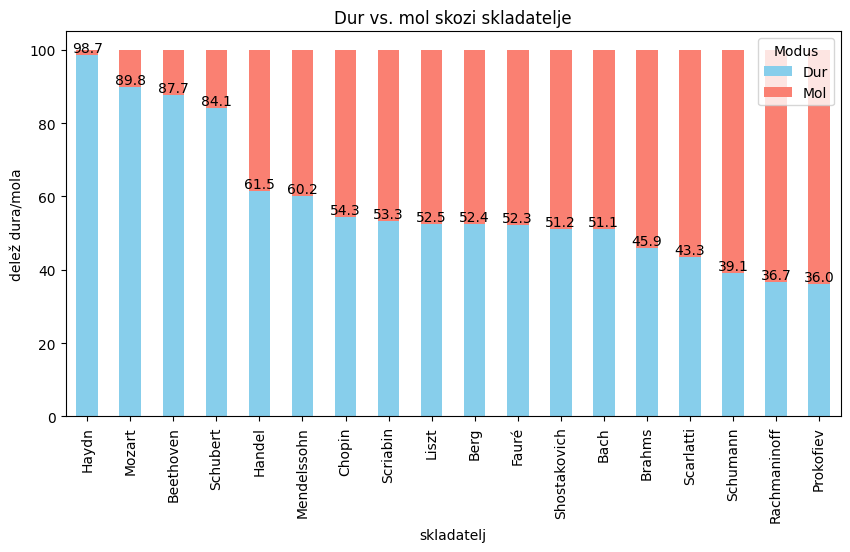

In [18]:
def modus(tonaliteta):
    if 'dur' in tonaliteta:
        return 'Dur'
    else:
        return 'Mol'

df_tonalitete_del['modus'] = df_tonalitete_del['tonalitete_delov'].apply(modus)

stevilo_modusov = df_tonalitete_del.dropna(subset='tonalitete_delov').groupby('priimek').filter(lambda x: len(x) >= 10).groupby(['priimek', 'modus']).size().unstack(fill_value=0)
delez_modusov = stevilo_modusov.div(stevilo_modusov.sum(axis=1), axis=0) * 100

ax = delez_modusov[['Dur', 'Mol']].sort_values(by='Mol').plot(kind='bar', stacked=True, figsize=(10,5), color=['skyblue', 'salmon'])
plt.title('Dur vs. mol skozi skladatelje')
plt.bar_label(ax.containers[0], fmt='%.1f')
plt.xlabel('skladatelj')
plt.ylabel('delež dura/mola')
plt.legend(title='Modus')
plt.show()

Zmagal (oz. zgubil) je Prokofiev, modernejši skladatelj, znan po svojih disonančnih kompozicijah, polnih industrijske in vojaške atmosfere. Družbo mu delajo nekateri romantiki in presenetljivo tudi Scarlatti.

Zgubil (oz. zmagal) pa je Haydn, katerega dela so že od nekdaj znana po svoji ekstatični, veseli in humorni naravi. Citiram Karla Geiringerja:
>Out of Haydn's love for the beauties of our world grew the gaiety and affirmative spirit apparent throughout all his creative periods ... Even in his advanced age, this gaiety did not entirely desert him. Nurtured by ... a victorious optimism maintained through all the vicissitudes of a long and arduous life, this radiant joyfulness again and again manifested itself, and Haydn considered it his mission to let his fellow beings share in this unique gift.

Podobno pravi tudi Charles Rosen:
>Haydn's ability to create an emotion that was completely his own and that no other composer could duplicate – a feeling of ecstasy that is completely unsensual, almost amiable. There is no recipe for producing this effect ...

Za konec pa si, bolj za hec kot za res, poglejmo še povprečen tempo skladb različnih skladateljev. S tem bomo odgovorili na večno vprašanje: kateri skladatelj je najposkočnejši?

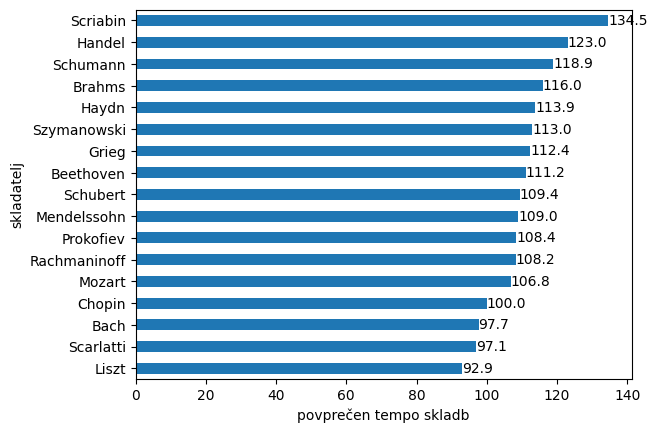

In [19]:
df_tempi_delov = df_skladbe.explode('tempi_delov')
df_tempi_delov = df_tempi_delov.dropna(subset='tempi_delov')
df_tempi_delov = df_tempi_delov.groupby('priimek').filter(lambda x: len(x) >= 10)
ax = df_tempi_delov.groupby('priimek')['tempi_delov'].mean().sort_values().plot(kind='barh')
plt.bar_label(ax.containers[0], fmt='%.1f')
plt.xlabel('povprečen tempo skladb')
plt.ylabel('skladatelj')
plt.show()

Seveda smo tu odstranili skladatelje, ki imajo premalo relevantnih podatkov. Zato pa me je Scriabinov rezultat sprva toliko bolj presenetil, saj me njegova dela ponavadi navdajo ali z globokim psihološkim strahom ali pa z ekstazo, zelo redko se mi zdijo "poskočna". Resničen razlog za njegovo zmago je to, da je večina njegovih del polna zelo gostih tekstur in hitrega menjavanja tem.

## Zaključek

Kljub temu da se z glasbo ukvarjam že dolgo in mi je veliko, kar smo ugotovili, že znano, me je vseeno presenetilo, kako jasno so podatki ta dejstva prikazali. Najboljši primer tega je graf odvisnosti modusa od petdesetletja, kjer smo kljub pomanjkljivostim v podatkih o tonaliteti pridobili sliko, ki se je ujemala s tistim, kar sem izvedel v šolah. Vseeno pa sem izvedel tudi veliko novega: o Scarlattijevem ogromnem opusu prej nisem vedel skoraj ničesar, presenetilo me je, kako malo se je običajno trajanje skladb spreminjalo skozi čas, nisem si predstavljal, da so duri res toliko pogostejši od molov, ...

Iz podatkov smo iztisnili skoraj vse, kar se iz podatkov iztisniti da. Za naprednejšo analizo skladb bi bilo potrebno imeti na razpolago npr. notni zapis del, da bi lahko za prav vsako določili tonaliteto in tempo, morda pa tudi katere zapletenejše podatke, kot so harmonije in motivi. To nalogo prepuščam bralcu.